# Lab 3A: Low-Level Feature Extraction
**Course:** AIML ZG531 - Video Analysis  
**Module:** 3 - Feature Extraction  
**Topic:** Edge, Corner, Texture, and Color Features from Video  
**Author:** Seetha Parameswaran

---

## Learning Objectives
- Extract and visualize low-level spatial features from video frames
- Compare edge detection methods (Canny vs. Sobel)
- Apply corner detection algorithms (Harris vs. Shi-Tomasi)
- Compute texture descriptors using Local Binary Patterns
- Analyze color distributions through histogram features
- Understand the role of hand-crafted features in video analysis


This script extracts low-level spatial features from video frames:
1. Edge Detection (Canny, Sobel)
2. Corner Detection (Harris, Shi-Tomasi)
3. Texture Features (Local Binary Patterns)
4. Color Histograms


In [1]:
import cv2
import numpy as np
from skimage.feature import local_binary_pattern
import matplotlib.pyplot as plt
from pathlib import Path
import os


class LowLevelFeatureExtractor:
    """Extract low-level features from video frames"""
    
    def __init__(self, video_path):
        """
        Initialize feature extractor
        
        Args:
            video_path: Path to input video file
        """
        self.video_path = video_path
        self.cap = cv2.VideoCapture(video_path)
        
        if not self.cap.isOpened():
            raise ValueError(f"Cannot open video file: {video_path}")
        
        # Get video properties
        self.fps = self.cap.get(cv2.CAP_PROP_FPS)
        self.total_frames = int(self.cap.get(cv2.CAP_PROP_FRAME_COUNT))
        self.width = int(self.cap.get(cv2.CAP_PROP_FRAME_WIDTH))
        self.height = int(self.cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
        
        print(f"Video Properties:")
        print(f"  Resolution: {self.width}x{self.height}")
        print(f"  FPS: {self.fps}")
        print(f"  Total Frames: {self.total_frames}")
    
    def extract_edges_canny(self, frame, low_threshold=50, high_threshold=150):
        """
        Extract edges using Canny edge detector
        
        Args:
            frame: Input frame (BGR)
            low_threshold: Lower threshold for hysteresis
            high_threshold: Upper threshold for hysteresis
            
        Returns:
            Edge map
        """
        gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        edges = cv2.Canny(gray, low_threshold, high_threshold)
        return edges
    
    def extract_edges_sobel(self, frame):
        """
        Extract edges using Sobel operator
        
        Args:
            frame: Input frame (BGR)
            
        Returns:
            Edge magnitude map
        """
        gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        
        # Compute gradients in x and y directions
        sobel_x = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=3)
        sobel_y = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=3)
        
        # Compute gradient magnitude
        magnitude = np.sqrt(sobel_x**2 + sobel_y**2)
        magnitude = np.uint8(255 * magnitude / np.max(magnitude))
        
        return magnitude
    
    def extract_corners_harris(self, frame, block_size=2, ksize=3, k=0.04, threshold=0.01):
        """
        Detect corners using Harris corner detector
        
        Args:
            frame: Input frame (BGR)
            block_size: Size of neighborhood for corner detection
            ksize: Aperture parameter for Sobel operator
            k: Harris detector free parameter
            threshold: Threshold for corner response (relative to max)
            
        Returns:
            Corner map, corner coordinates
        """
        gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        gray = np.float32(gray)
        
        # Detect corners
        dst = cv2.cornerHarris(gray, block_size, ksize, k)
        
        # Threshold for corner detection
        corner_map = dst > threshold * dst.max()
        
        # Get corner coordinates
        corners = np.argwhere(corner_map)
        
        return corner_map.astype(np.uint8) * 255, corners
    
    def extract_corners_shi_tomasi(self, frame, max_corners=100, quality_level=0.01, min_distance=10):
        """
        Detect corners using Shi-Tomasi (Good Features to Track)
        
        Args:
            frame: Input frame (BGR)
            max_corners: Maximum number of corners to detect
            quality_level: Quality threshold (0-1)
            min_distance: Minimum distance between corners
            
        Returns:
            Corner coordinates
        """
        gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        
        # Detect corners
        corners = cv2.goodFeaturesToTrack(
            gray,
            maxCorners=max_corners,
            qualityLevel=quality_level,
            minDistance=min_distance
        )
        
        return corners
    
    def extract_texture_lbp(self, frame, num_points=8, radius=1):
        """
        Extract texture features using Local Binary Patterns
        
        Args:
            frame: Input frame (BGR)
            num_points: Number of circularly symmetric neighbor points
            radius: Radius of circle
            
        Returns:
            LBP feature map, LBP histogram
        """
        gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        
        # Compute LBP
        lbp = local_binary_pattern(gray, num_points, radius, method='uniform')
        
        # Compute LBP histogram
        n_bins = num_points + 2  # uniform patterns + non-uniform
        hist, _ = np.histogram(lbp.ravel(), bins=n_bins, range=(0, n_bins))
        
        # Normalize histogram
        hist = hist.astype("float")
        hist /= (hist.sum() + 1e-7)
        
        return lbp.astype(np.uint8), hist
    
    def extract_color_histogram(self, frame, bins=32):
        """
        Extract color histogram features
        
        Args:
            frame: Input frame (BGR)
            bins: Number of bins per channel
            
        Returns:
            Histograms for each channel (B, G, R)
        """
        histograms = []
        colors = ('b', 'g', 'r')
        
        for i, color in enumerate(colors):
            hist = cv2.calcHist([frame], [i], None, [bins], [0, 256])
            hist = hist.flatten()
            hist = hist / (hist.sum() + 1e-7)  # Normalize
            histograms.append(hist)
        
        return histograms
    
    def process_frame(self, frame_idx):
        """
        Extract all low-level features from a single frame
        
        Args:
            frame_idx: Frame index to process
            
        Returns:
            Dictionary containing all extracted features
        """
        # Set frame position
        self.cap.set(cv2.CAP_PROP_POS_FRAMES, frame_idx)
        ret, frame = self.cap.read()
        
        if not ret:
            raise ValueError(f"Cannot read frame {frame_idx}")
        
        features = {}
        
        # Edge features
        features['edges_canny'] = self.extract_edges_canny(frame)
        features['edges_sobel'] = self.extract_edges_sobel(frame)
        
        # Corner features
        harris_map, harris_coords = self.extract_corners_harris(frame)
        features['corners_harris_map'] = harris_map
        features['corners_harris_coords'] = harris_coords
        
        shi_tomasi_corners = self.extract_corners_shi_tomasi(frame)
        features['corners_shi_tomasi'] = shi_tomasi_corners
        
        # Texture features
        lbp_map, lbp_hist = self.extract_texture_lbp(frame)
        features['texture_lbp_map'] = lbp_map
        features['texture_lbp_hist'] = lbp_hist
        
        # Color features
        color_hists = self.extract_color_histogram(frame)
        features['color_hist_b'] = color_hists[0]
        features['color_hist_g'] = color_hists[1]
        features['color_hist_r'] = color_hists[2]
        
        # Store original frame
        features['original_frame'] = frame
        
        return features
    
    def visualize_features(self, features, save_path=None):
        """
        Visualize extracted features
        
        Args:
            features: Dictionary of extracted features
            save_path: Path to save visualization (optional)
        """
        fig = plt.figure(figsize=(16, 12))
        
        # Original frame
        ax1 = plt.subplot(3, 4, 1)
        frame_rgb = cv2.cvtColor(features['original_frame'], cv2.COLOR_BGR2RGB)
        ax1.imshow(frame_rgb)
        ax1.set_title('Original Frame')
        ax1.axis('off')
        
        # Canny edges
        ax2 = plt.subplot(3, 4, 2)
        ax2.imshow(features['edges_canny'], cmap='gray')
        ax2.set_title('Canny Edges')
        ax2.axis('off')
        
        # Sobel edges
        ax3 = plt.subplot(3, 4, 3)
        ax3.imshow(features['edges_sobel'], cmap='gray')
        ax3.set_title('Sobel Edges')
        ax3.axis('off')
        
        # Harris corners
        ax4 = plt.subplot(3, 4, 4)
        frame_with_harris = frame_rgb.copy()
        if len(features['corners_harris_coords']) > 0:
            for y, x in features['corners_harris_coords'][:100]:  # Limit for visualization
                cv2.circle(frame_with_harris, (x, y), 3, (255, 0, 0), -1)
        ax4.imshow(frame_with_harris)
        ax4.set_title(f'Harris Corners ({len(features["corners_harris_coords"])})')
        ax4.axis('off')
        
        # Shi-Tomasi corners
        ax5 = plt.subplot(3, 4, 5)
        frame_with_shi_tomasi = frame_rgb.copy()
        if features['corners_shi_tomasi'] is not None:
            for corner in features['corners_shi_tomasi']:
                x, y = corner.ravel()
                cv2.circle(frame_with_shi_tomasi, (int(x), int(y)), 3, (0, 255, 0), -1)
        ax5.imshow(frame_with_shi_tomasi)
        ax5.set_title(f'Shi-Tomasi Corners ({len(features["corners_shi_tomasi"]) if features["corners_shi_tomasi"] is not None else 0})')
        ax5.axis('off')
        
        # LBP texture
        ax6 = plt.subplot(3, 4, 6)
        ax6.imshow(features['texture_lbp_map'], cmap='gray')
        ax6.set_title('LBP Texture Map')
        ax6.axis('off')
        
        # LBP histogram
        ax7 = plt.subplot(3, 4, 7)
        ax7.bar(range(len(features['texture_lbp_hist'])), features['texture_lbp_hist'])
        ax7.set_title('LBP Histogram')
        ax7.set_xlabel('LBP Pattern')
        ax7.set_ylabel('Frequency')
        
        # Color histograms
        ax8 = plt.subplot(3, 4, 8)
        colors = ['blue', 'green', 'red']
        for i, (hist, color) in enumerate(zip(
            [features['color_hist_b'], features['color_hist_g'], features['color_hist_r']],
            colors
        )):
            ax8.plot(hist, color=color, alpha=0.7, label=color.upper())
        ax8.set_title('Color Histograms')
        ax8.set_xlabel('Bin')
        ax8.set_ylabel('Frequency')
        ax8.legend()
        
        # Edge statistics
        ax9 = plt.subplot(3, 4, 9)
        edge_stats = {
            'Canny': np.sum(features['edges_canny'] > 0),
            'Sobel': np.sum(features['edges_sobel'] > 128)
        }
        ax9.bar(edge_stats.keys(), edge_stats.values())
        ax9.set_title('Edge Pixel Count')
        ax9.set_ylabel('Count')
        
        # Corner statistics
        ax10 = plt.subplot(3, 4, 10)
        corner_stats = {
            'Harris': len(features['corners_harris_coords']),
            'Shi-Tomasi': len(features['corners_shi_tomasi']) if features['corners_shi_tomasi'] is not None else 0
        }
        ax10.bar(corner_stats.keys(), corner_stats.values())
        ax10.set_title('Corner Count')
        ax10.set_ylabel('Count')
        
        plt.tight_layout()
        
        if save_path:
            plt.savefig(save_path, dpi=150, bbox_inches='tight')
            print(f"Visualization saved to: {save_path}")
        
        plt.show()
    
    def process_video_sample(self, sample_frames=5, output_dir='features_output'):
        """
        Process sample frames from the video
        
        Args:
            sample_frames: Number of frames to sample
            output_dir: Directory to save outputs
        """
        # Create output directory
        os.makedirs(output_dir, exist_ok=True)
        
        # Sample frame indices uniformly
        frame_indices = np.linspace(0, self.total_frames - 1, sample_frames, dtype=int)
        
        print(f"\nProcessing {sample_frames} sample frames...")
        
        for i, frame_idx in enumerate(frame_indices):
            print(f"\nProcessing frame {frame_idx}/{self.total_frames} ({i+1}/{sample_frames})...")
            
            # Extract features
            features = self.process_frame(frame_idx)
            
            # Visualize and save
            save_path = os.path.join(output_dir, f'features_frame_{frame_idx:06d}.png')
            self.visualize_features(features, save_path=save_path)
            
            # Print statistics
            print(f"  Harris corners: {len(features['corners_harris_coords'])}")
            print(f"  Shi-Tomasi corners: {len(features['corners_shi_tomasi']) if features['corners_shi_tomasi'] is not None else 0}")
            print(f"  Canny edge pixels: {np.sum(features['edges_canny'] > 0)}")
            print(f"  LBP histogram entropy: {-np.sum(features['texture_lbp_hist'] * np.log(features['texture_lbp_hist'] + 1e-7)):.3f}")
    
    def __del__(self):
        """Release video capture"""
        if hasattr(self, 'cap'):
            self.cap.release()




Low-Level Feature Extraction from Video
Module 3: Video Analysis
Video Properties:
  Resolution: 320x240
  FPS: 29.97002997002997
  Total Frames: 103

Processing 5 sample frames...

Processing frame 0/103 (1/5)...
Visualization saved to: low_level_features\features_frame_000000.png


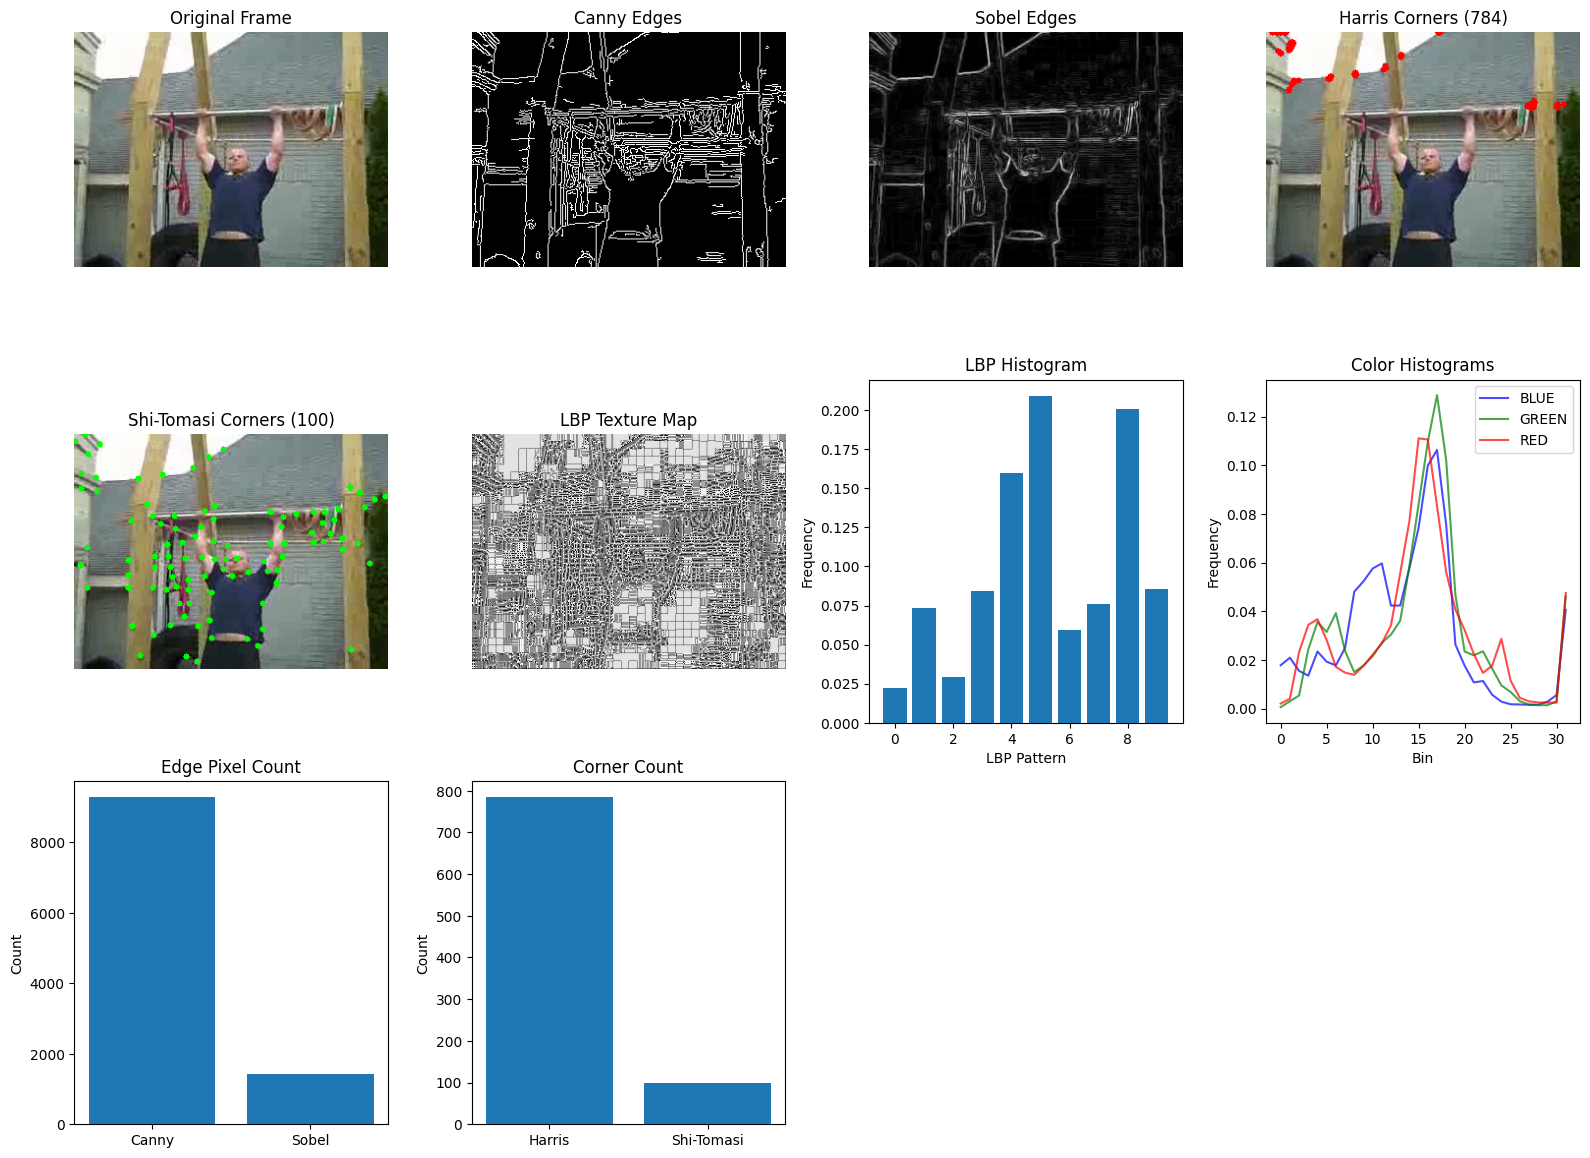

  Harris corners: 784
  Shi-Tomasi corners: 100
  Canny edge pixels: 9276
  LBP histogram entropy: 2.105

Processing frame 25/103 (2/5)...
Visualization saved to: low_level_features\features_frame_000025.png


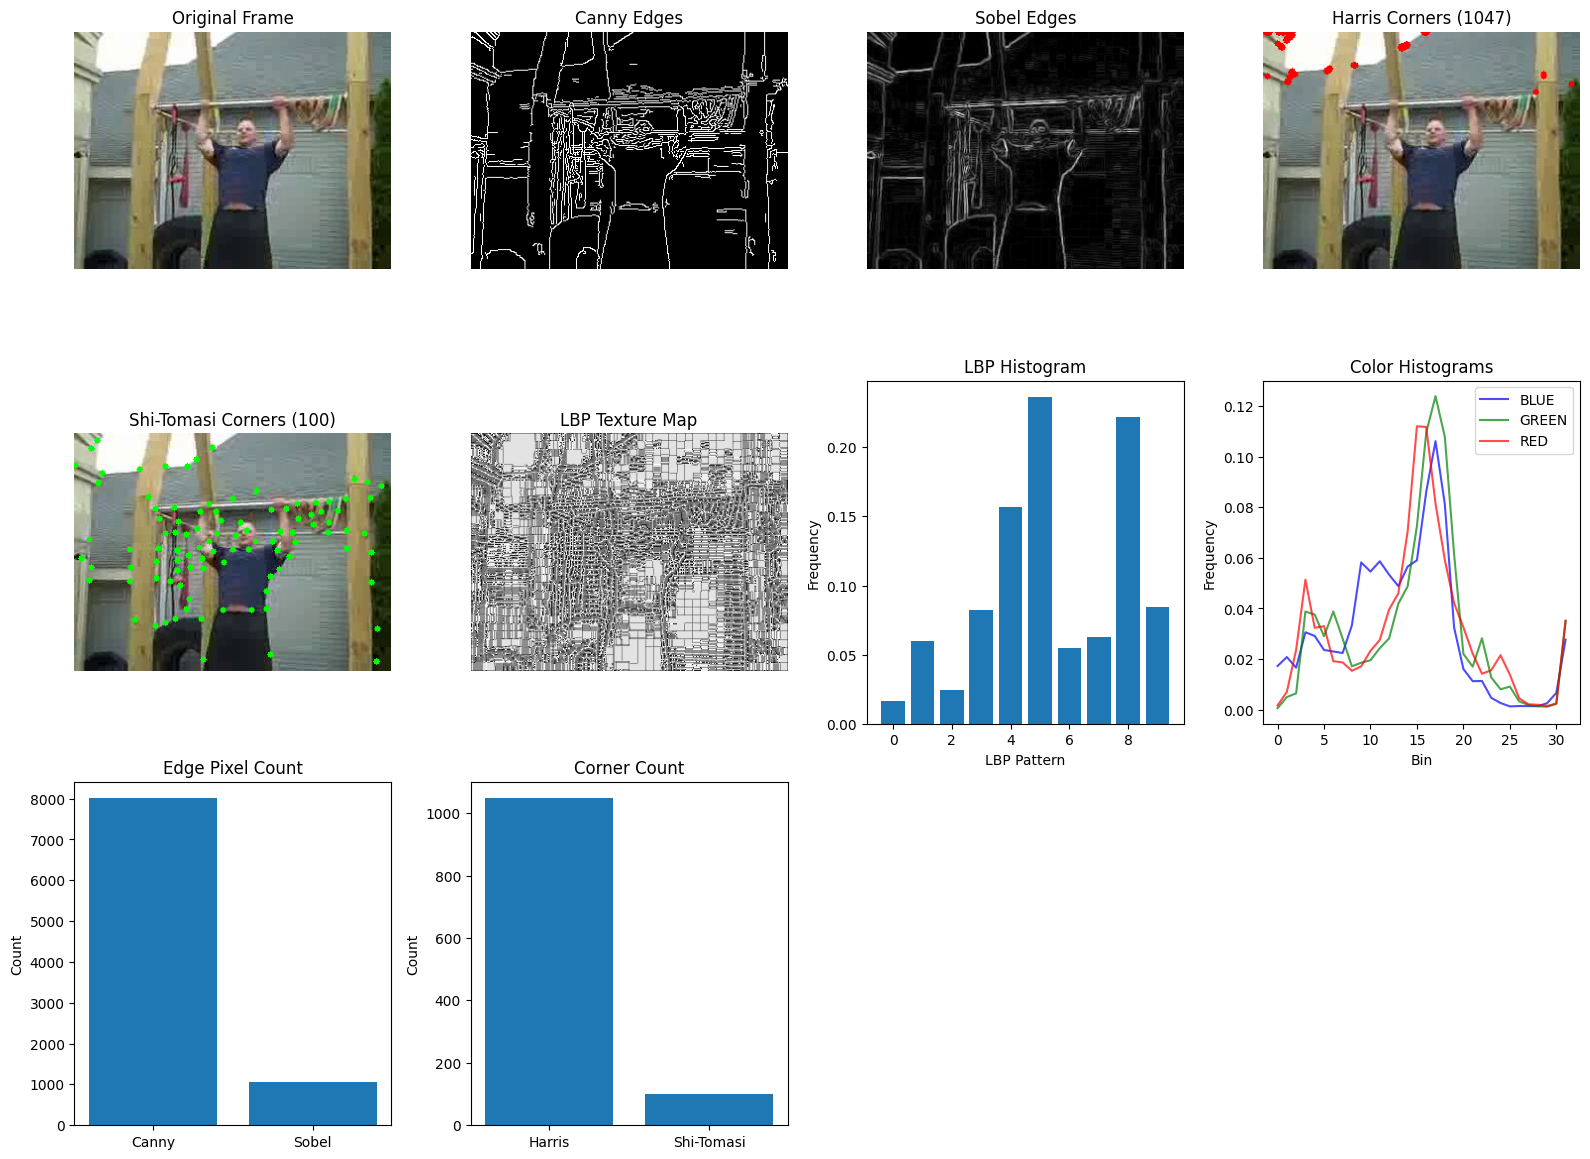

  Harris corners: 1047
  Shi-Tomasi corners: 100
  Canny edge pixels: 8007
  LBP histogram entropy: 2.039

Processing frame 51/103 (3/5)...
Visualization saved to: low_level_features\features_frame_000051.png


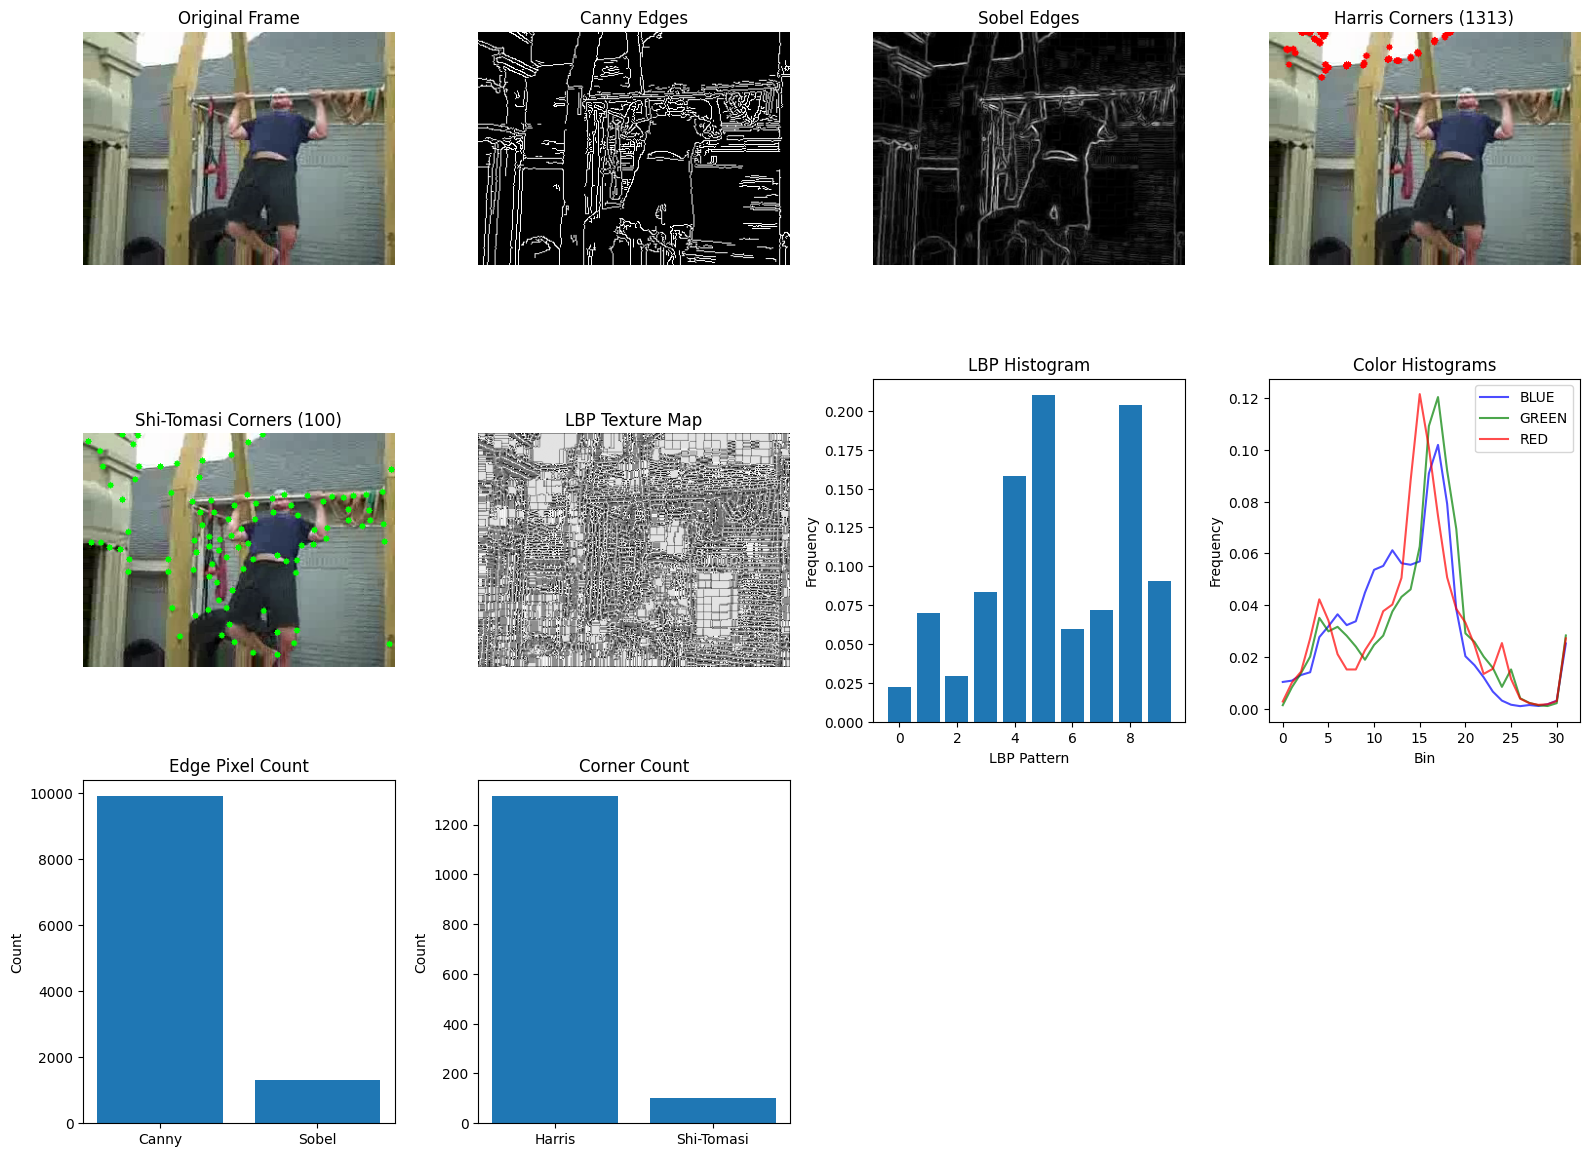

  Harris corners: 1313
  Shi-Tomasi corners: 100
  Canny edge pixels: 9893
  LBP histogram entropy: 2.102

Processing frame 76/103 (4/5)...
Visualization saved to: low_level_features\features_frame_000076.png


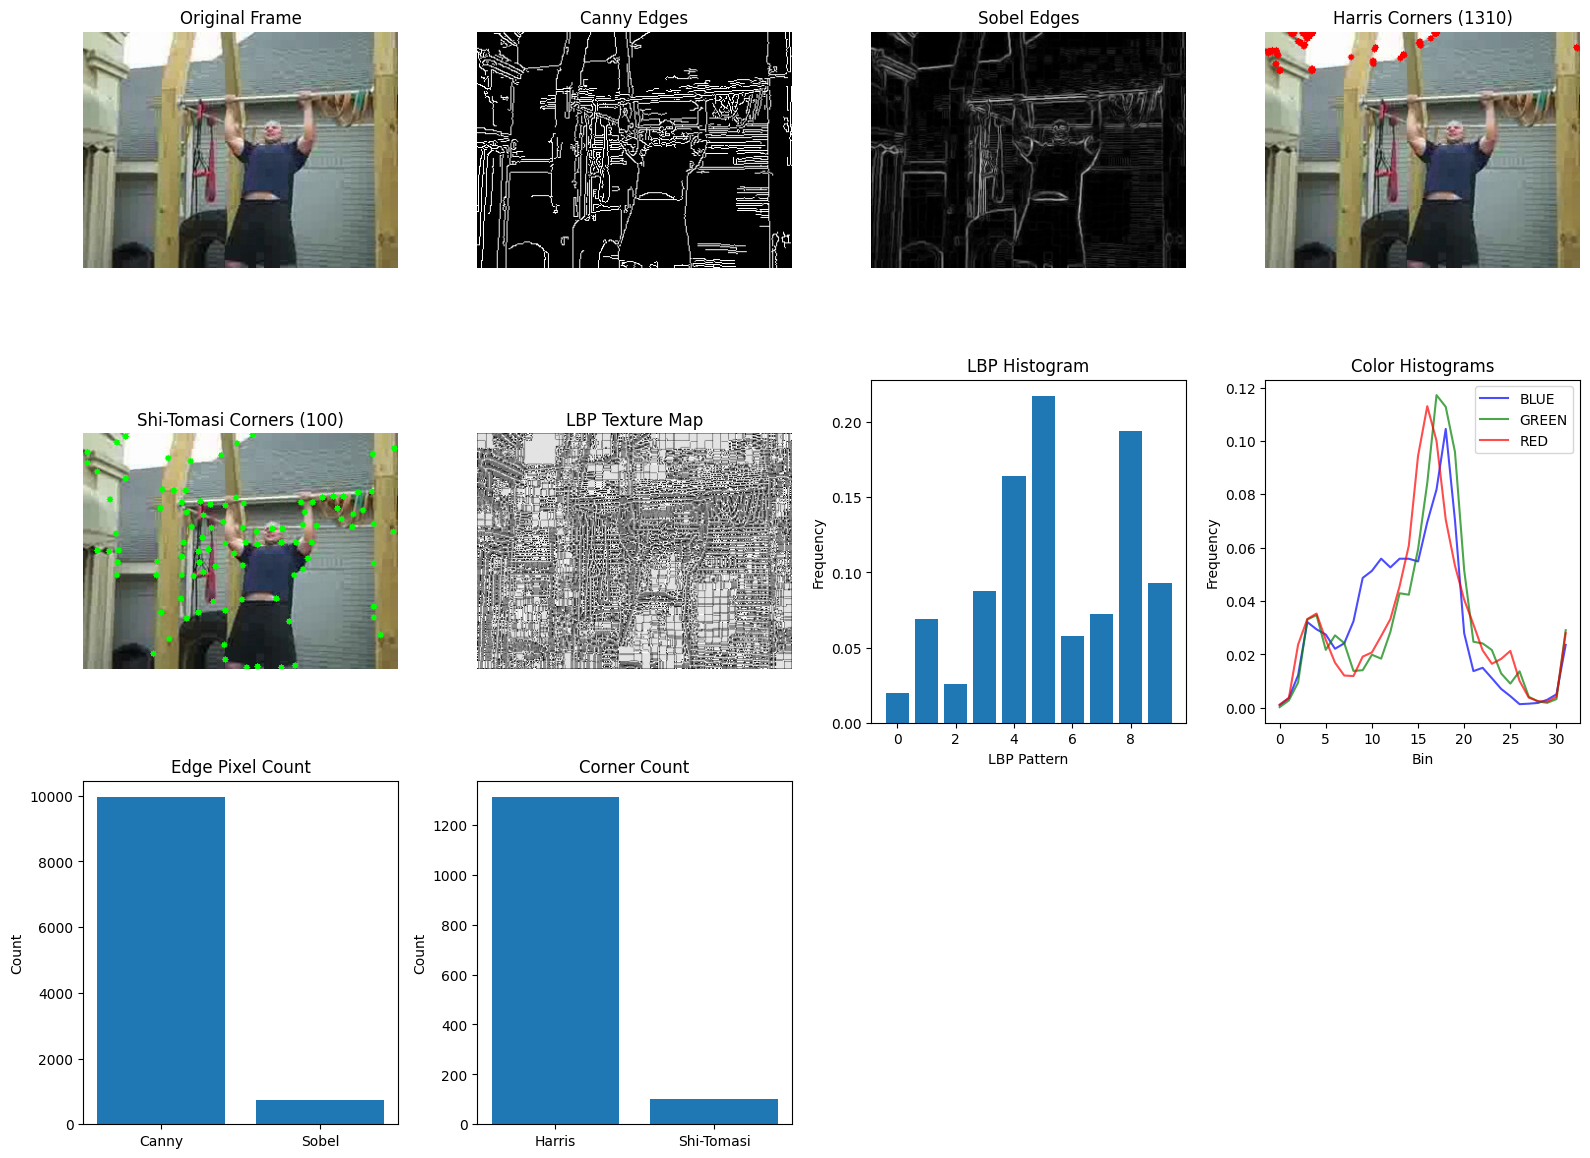

  Harris corners: 1310
  Shi-Tomasi corners: 100
  Canny edge pixels: 9952
  LBP histogram entropy: 2.091

Processing frame 102/103 (5/5)...
Visualization saved to: low_level_features\features_frame_000102.png


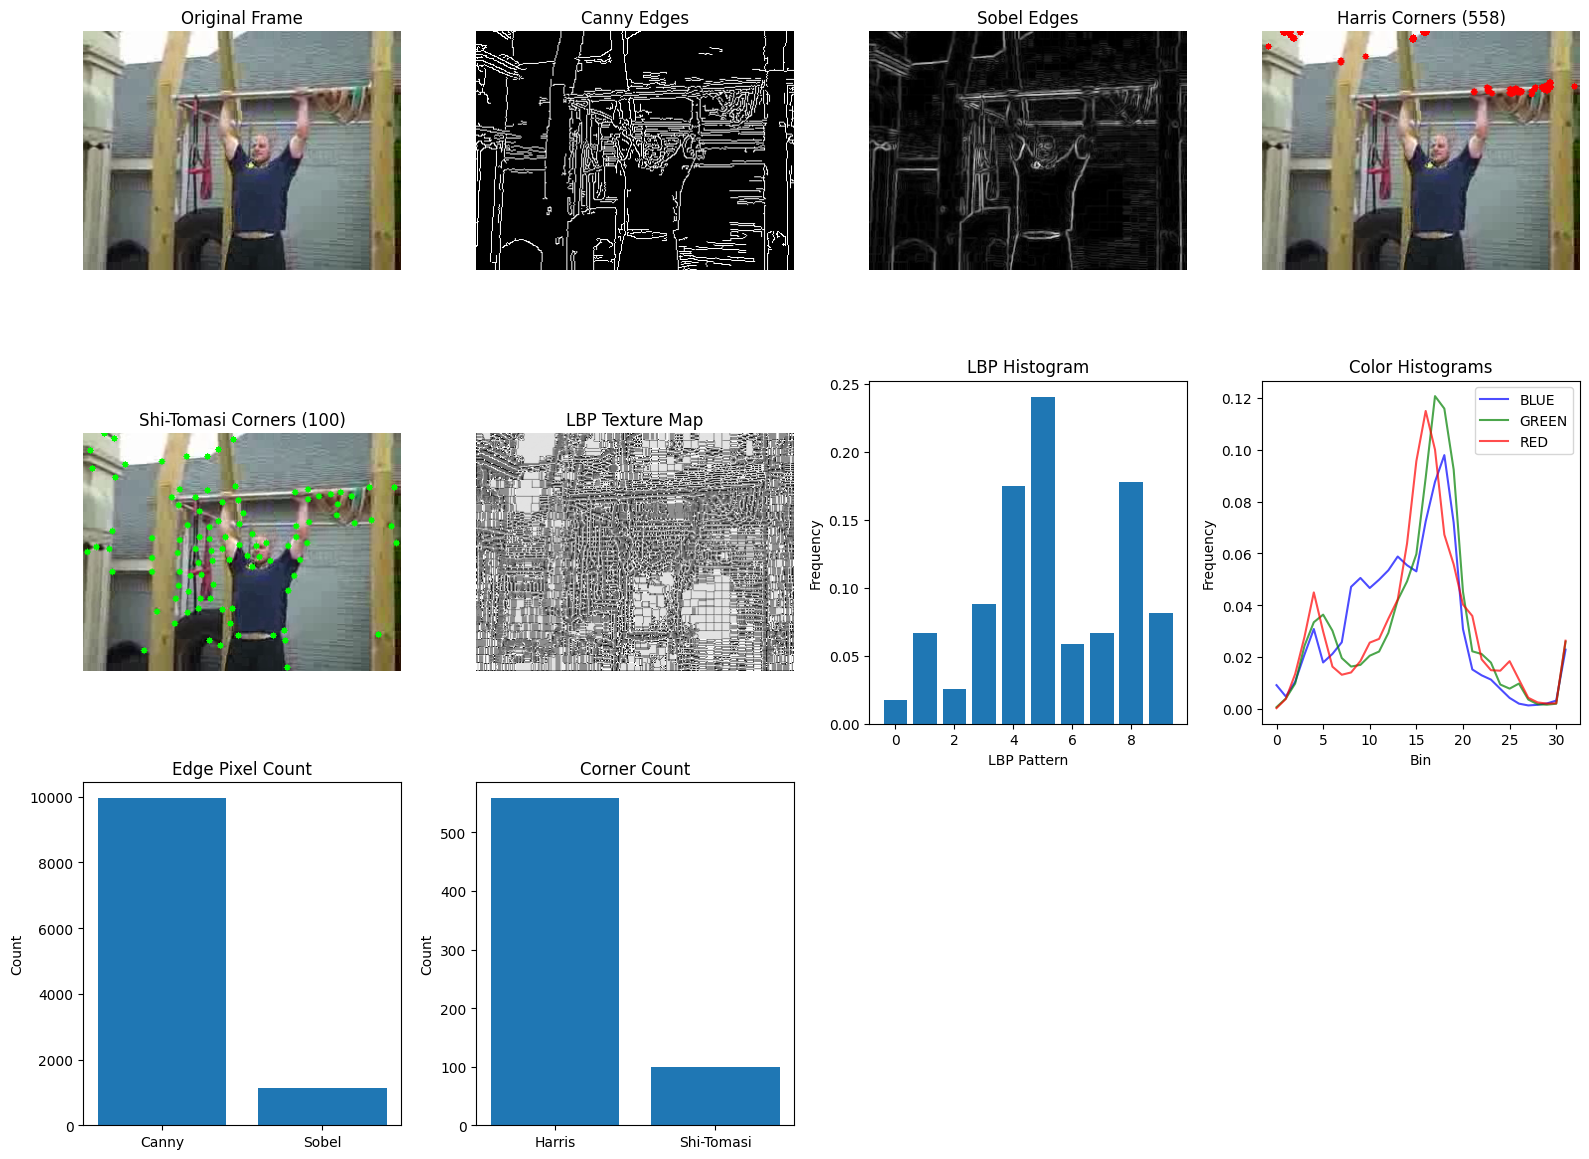

  Harris corners: 558
  Shi-Tomasi corners: 100
  Canny edge pixels: 9948
  LBP histogram entropy: 2.068

Feature extraction completed successfully!


In [2]:
def main():
    """Main function to demonstrate feature extraction"""
    
    # Example usage
    video_path = "vid.avi"  # Replace with your video path
    
    print("=" * 60)
    print("Low-Level Feature Extraction from Video")
    print("Module 3: Video Analysis")
    print("=" * 60)
    
    try:
        # Initialize extractor
        extractor = LowLevelFeatureExtractor(video_path)
        
        # Process sample frames
        extractor.process_video_sample(sample_frames=5, output_dir='low_level_features')
        
        print("\n" + "=" * 60)
        print("Feature extraction completed successfully!")
        print("=" * 60)
        
    except Exception as e:
        print(f"\nError: {str(e)}")
        print("\nPlease ensure:")
        print("1. Video file exists at the specified path")
        print("2. Required libraries are installed: opencv-python, scikit-image, matplotlib")
        print("\nInstall with: pip install opencv-python scikit-image matplotlib numpy")


if __name__ == "__main__":
    main()

## Summary and Key Takeaways

### Feature Categories

1. **Edge Features**
   - Canny: Multi-stage, hysteresis thresholding, optimal edge detection
   - Sobel: Gradient-based, simple, fast computation
   - Use case: Object boundaries, motion boundaries

2. **Corner Features**
   - Harris: Classic, rotation-invariant, good for tracking
   - Shi-Tomasi: Improved quality measure, better feature distribution
   - Use case: Feature tracking, structure from motion

3. **Texture Features**
   - LBP: Rotation-invariant, efficient, local patterns
   - Histogram: Statistical texture characterization
   - Use case: Material classification, face recognition

4. **Color Features**
   - Channel histograms: Distribution-based representation
   - Normalized: Scale-invariant, illumination robust
   - Use case: Object recognition, scene understanding

### Practical Insights
- **Complementary Nature:** Different features capture different aspects
- **Computational Cost:** Hand-crafted features are fast but limited
- **Robustness:** Corner features more stable across frames than edges
- **Dimensionality:** Color/texture features are compact representations

---

## Exercise Questions

1. **Conceptual**: Why do corner features remain more stable across frames compared to edge features in video sequences?

2. **Analysis**: Compare Harris and Shi-Tomasi corner counts. Which method provides better spatial distribution? Why might this matter for tracking?

3. **Application**: For a gait analysis system (medical case study), which low-level features would be most useful for detecting key body points? Justify your choice.

4. **Implementation**: Modify the code to extract features at multiple scales. How does scale affect edge and corner detection?

5. **Critical Thinking**: LBP histograms lose spatial information. Propose a method to retain spatial structure while using LBP features.

6. **Comparison**: Calculate the correlation between LBP histogram entropy and edge pixel count across frames. What does this relationship indicate?